In [1]:
# Shubham Singh
# 21250025
# Assignment-6 & 7
# Task-3a

#Secret Code: DEV


#Puma Robot

import numpy as np
import sympy as sp
from math import factorial, comb
import re
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle
from abc import ABC, abstractmethod
from scipy.integrate import odeint
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.integrate import odeint

class PolynomialGenerator():                                  #Desired trajectory from Task-1
    def __init__(self):
        pass

    def generate_coefficients(self, q_init, q_final, t_f=5.0, t_0=0.0):
        A_0 = self._get_constraint_submatrix(t_0)
        A_f = self._get_constraint_submatrix(t_f)
        A = np.vstack((A_0, A_f))
        q = np.hstack((np.array(q_init), np.array(q_final)))
        return np.linalg.inv(A).dot(q)

    def _get_constraint_submatrix(self, t):
        A = np.array([[1, t, t**2, t**3, t**4, t**5],
                      [0, 1, 2 * t, 3 * t**2, 4 * t**3, 5 * t**4],
                      [0, 0, 2, 6 * t, 12 * t**2, 20 * t**3]])
        return A

    def polynomial_from_coefs(self, coefs, from_t, to_t, n):
        ts = np.linspace(from_t, to_t, n)
        poly = 0
        for i, coef in enumerate(coefs):
            poly += coef * ts**i
        return poly

    def dpolynomial_from_coefs(self, d, coefs, from_t, to_t, n):
        ts = np.linspace(from_t, to_t, n)
        poly = 0
        if d >= len(coefs):
            return np.zeros(n)
        for i, coef in enumerate(coefs[d:], d):
            poly += coef * factorial(d) * comb(i, d) * ts**(i - d)
        return poly

class TrajectoryGenerator():

    def __init__(self, dq_max, ddq_max, dx_max, ddx_max, control_freq=0):
        self._pg = PolynomialGenerator()
        self._dq_max = dq_max
        self._ddq_max = ddq_max
        self._dx_max = dx_max
        self._ddx_max = ddx_max
        self._control_freq = control_freq

    def generate_joint_poly_trajectory(self,qs_0,qs_f,t_f,t_0=0.0,n=10,plot=True):
                                                                                    # Generate polynomial coefficients
        coefs = []
        for q_0, q_f in zip(qs_0, qs_f):
            coefs.append(self._pg.generate_coefficients(q_0, q_f, t_f, t_0))
        qs, dqs, ddqs, qs_del_ = [], [], [], []
        for c in coefs:
            qs.append(self._pg.polynomial_from_coefs(c, t_0, t_f, n))
            qs_del_.append(self._pg.polynomial_from_coefs(c,t_0, t_f,n))
            if plot:
                dqs.append(self._pg.dpolynomial_from_coefs(1, c, t_0, t_f, n))
                ddqs.append(self._pg.dpolynomial_from_coefs(2, c, t_0, t_f, n))
        qs_ = np.array(qs).T - 0.005/2
        qs_del= np.delete(qs_, 2, 1)
        qs_del_= np.delete(qs_del, 1, 1)
        
        if plot:
            ts = np.linspace(t_0, t_f, n)
            TrajectoriesPlotter.plot_joint(ts, qs, qs_del_)
        return np.array(qs).T, np.array(qs_del_)        

class TrajectoriesPlotter():
    def plot_joint(ts, qs, qs_del_):
        rc('text', usetex=False)
        fig, axs = plt.subplots(1, 2, sharex=True, figsize=(8, 5))
        fig.suptitle("TasK-3(a)_End Effector trajectory (Actual Vs Desired)",size = 15, fontweight="bold")
        labels = ["", r"\dot", r"\ddot"]        
        for i, (q) in enumerate((qs)):
            plots = [q]            
        for j, (plot, label) in enumerate(zip(plots, labels)):
                axs[j].plot(ts, plot, "-b", label="Actual")
                axs[0].plot(ts, qs_del_, "-r", label="Desired")
                axs[0].legend(loc="lower left")                
                axs[j].set_xlabel(f'$t (s)$')                          
        plt.tight_layout()
        plt.show()

In [2]:
class Robot(ABC):
    epsilon = 1e-5
    @abstractmethod
    def inverse_kinematics(self, T):
         pass
    def set_transforms(self, T_base=None, T_tool=None):
        if T_base is None:
            self.T_base = sp.eye(4)
        else:
            self.T_base = sp.Matrix(T_base)
        if T_tool is None:
            self.T_tool = sp.eye(4)
        else:
            self.T_tool = sp.Matrix(T_tool)

    def set_lengths(self, lengths):
        if lengths is None:
            self._ls = (0.8, 0.8)
        else:
            self._ls = lengths
        return Robot
        
class Puma(Robot):
    ls = (2.0, 2.0, 2.0)                                                  #Length of Links
    qs_lim_deg = ((-360.0, 360.0),
                  (-360.0, 360.0),
                  (-360.0, 360.0))

    def __init__(self, T_base=None, T_tool=None):
    
        self.set_transforms(T_base, T_tool)

        self._generate_value_pairs()
        self._calculate_limits_radians() 
     
    def _generate_value_pairs(self):
        value_pairs = []
        for i in range(len(self.ls)):
            value_pairs.append((f"l_{i}", self.ls[i]))
        self._value_pairs = value_pairs

    def _calculate_limits_radians(self):   
        self.qs_lim_rad = tuple(
            (np.deg2rad(x[0]), np.deg2rad(x[1])) for x in self.qs_lim_deg)

    def _show_fk(self):
    
        frames = [self.T_base]

        for frame, var in zip(self._numeric_frames, self._Ts.variables):
            if var[0] == 'q':
                frames.append(self.T_base * frame)

        frames.append(self.T_base * self._numeric_frames[-1])
        frames.append(frames[-1] * self.T_tool)

    def inverse_kinematics(self, T, m=1, k=1):
        
        if abs(m) != 1:
            print("error")
            m = 1

        if abs(k) != 1:
            print("error")
            k = 1

        T = sp.Matrix(T)
        T_0 = self.T_base.inv() * T * self.T_tool.inv()

        x, y, z = float(T_0[0, 3]), float(T_0[1, 3]), float(T_0[2, 3])
        x_prime = k * np.sqrt(x**2 + y**2)
        z_prime = self.ls[0] - z

        arccos_numerator = x_prime**2 + \
            z_prime**2 - self.ls[1]**2 - self.ls[2]**2
        arccos_denominator = 2.0 * self.ls[1] * self.ls[2]
        arccos = arccos_numerator / arccos_denominator

      
        if abs(arccos) > 1:                                  #workspace check
            print("Not in workspace")
            return np.array([0.0, 0.0, 0.0])

        q_2 = m * np.arccos(arccos)

        beta = np.arctan2(self.ls[2] * np.sin(m * q_2),
                          self.ls[1] + self.ls[2] * np.cos(q_2))
        q_1 = np.arctan2(z_prime, x_prime) - m * beta

        A = self.ls[1] * np.cos(q_1) + self.ls[2] * np.cos(q_1 + q_2)

        if abs(A) < self.epsilon:
            print("Arm up, q_0 = 0")
            q_0 = 0.0
        else:
            q_0 = np.arctan2(y, x)

        qs = np.array([q_0, q_1, q_2])

        out_of_limits = False
        for i in range(len(qs)):
            if qs[i] < self.qs_lim_rad[i][0] or qs[i] > self.qs_lim_rad[i][1]:
                print(f"[INFO] q_{i} = {np.rad2deg(qs[i]):.3f} "
                      f"error")
                out_of_limits = True
        if out_of_limits:
            return np.array([0.0, 0.0, 0.0])
        return qs

    def move_via_points(self, pts):
       
        plt.ion()
        Ts = []
        qs = []
        for pt in pts:
            for T in Ts:
                self.TrajectoriesPlotter.plot_position(T)

            self.TrajectoriesPlotter.ax.scatter(
                pts[0][0],
                pts[0][1],
                pts[0][2],
                c='red',
                s=40,
                alpha=0.6,
            )

            self.TrajectoriesPlotter.ax.scatter(
                pts[-1][0],
                pts[-1][1],
                pts[-1][2],
                c='red',
                s=40,
                alpha=0.6,
            )

            T_IK = np.array([
                [1, 0, 0, pt[0]],
                [0, 1, 0, pt[1]],
                [0, 0, 1, pt[2]],
                [0, 0, 0, 1]
            ])

            q = self.inverse_kinematics(T_IK)
            qs.append(q)
            T = self.forward_kinematics(q, plot=True)
            Ts.append(T)
        plt.ioff()
        return np.array(qs).T
dq_max = 1
ddq_max = 20
dx_max = 1
ddx_max = 10
n = 10
cf = 10

tg = TrajectoryGenerator(dq_max, ddq_max, dx_max, ddx_max, control_freq=cf)

# Polynomial joint trajectory
q_0 = [[0.4, 0.06, 0.1], [-0.9, 0, 0], [0.4, 0, 0]]                 # Initial Position, Velocity and acceleration 
q_f = [[0.4, 0.01, 0.1], [0.8, 0.2, 0], [0.6, 0.4, 0.4]]            # Final Position, velocity and acceleration
t_0, t_f = 0, 5

In [3]:
class JacobianCalculator():

    def __init__(self, sequence_string, joint_indices, f_of_t=True, variables=None, T_base=None, T_tool=None, simplify=False):
        self._seq = sequence_string
        self._tokens = SymbolicTransformation._tokens_from_sequence(self._seq)
        self._seq_numeric = []
        self._seq_skew = []
        self._vars_skew = []
        self._ind = joint_indices
        self._validator = SymbolicTransformation('')
        self.simplify = simplify

        self.set_transforms(T_base, T_tool)                                                     #Transformation of the frames            
        if len(self._tokens) != len(self._ind):
            raise ValueError("Size of indices does not match")

        elif type(f_of_t) == bool:
            self._f_of_t = [False] * len(self._ind)
            if f_of_t:
                self._f_of_t = self._ind
        else:
            self._f_of_t = f_of_t
        if variables is None:
            self._variables = []
            t_index = 0
            r_index = 0

            for token, index in zip(self._tokens, self._ind):
                if self._validator.valid_token(token):
                    if token.startswith('T'):
                        self._variables.append(f"d_{t_index}")
                        t_index += 1
                    elif token.startswith('R'):
                        self._variables.append(f"q_{r_index}")
                        r_index += 1
                else:
                    raise ValueError("transformation error")
        else:
            if len(variables) != len(self._tokens):
                raise ValueError("Transformation & variables sizes error")

            self._variables = variables
                                                                                    # Generate sequences for jacobian calculations
        for i, (token, index) in enumerate(zip(self._tokens, self._ind)):
            if index:
                self._seq_numeric.append(''.join(
                    self._tokens[:i] + [f"{token}d"] + self._tokens[i + 1:]))
                self._seq_skew.append(''.join(self._tokens[:i]))

        self._seq_skew.append(''.join(self._tokens))
        self._seq_numeric.append(''.join(self._tokens))

        for seq in self._seq_skew:
            n = len(st._tokens_from_sequence(seq))
            self._vars_skew.append(self._variables[:n])

    def set_transforms(self, T_base=None, T_tool=None):     # Updating base and tool transformations
        if T_base is None:
            self.T_base = sp.eye(4)
        else:
            self.T_base = sp.Matrix(T_base)
        if T_tool is None:
            self.T_tool = sp.eye(4)
        else:
            self.T_tool = sp.Matrix(T_tool)

    def calculate_numeric(self, T_base=None, T_tool=None):         #Calculates Jacobian matrix
        if T_base is None:
            T_base = self.T_base
        if T_tool is None:
            T_tool = self.T_tool
        T_robot = SymbolicTransformation(self._seq_numeric[-1],
                     self._variables,
                     f_of_t=self._f_of_t).transformation
        R = T_base * T_robot * T_tool
        R[0, 3] = R[1, 3] = R[2, 3] = 0.0
        Rt = R.T

        Jrs = []
        for seq in self._seq_numeric[:-1]:
            T_diff = SymbolicTransformation(seq,
                        self._variables,
                        f_of_t=self._f_of_t).transformation
            Jr = T_base * T_diff * T_tool * Rt
            Jrs.append(SymbolicTransformation.get_jacobian_column(Jr).T)

        if self.simplify:
            res = sp.simplify(sp.Matrix(Jrs).T)
        else:
            res = sp.Matrix(Jrs).T                           #calculated jacobian matrix
        return res

    def get_symbolic_jacobian_inverse():
        T_base = sp.eye(4)
        T_tool = sp.eye(4)
        variables = ['q_0', 'l_0', 'q_1', 'l_1', 'q_2', 'l_2']
        indices = [1, 0, 1, 0, 1, 0]
        sequence = "RzTzRyTxRyTx"
        jc = JacobianCalculator(sequence, indices, variables=variables, T_base=T_base, T_tool=T_tool, simplify=False)
        ls = (1.0, 1.0, 1.0)          #Length of links of the robot                                  
 
        value_pairs = []
        for i in range(len(ls)):
            value_pairs.append((f"l_{i}", ls[i]))

        J_inv = jc.calculate_numeric()[:3, :3].inv()
        J_inv = sp.simplify(J_inv.subs(value_pairs))

        with open('wb') as output:
            pickle.dump(J_inv, output, pickle.HIGHEST_PROTOCOL)

        return J_inv

    def main():
        T_base = sp.eye(4)
        T_tool = sp.eye(4)
        variables = ['q_0', 'l_0', 'q_1', 'l_1', 'q_2', 'l_2']
        indices = [1, 0, 1, 0, 1, 0]
        sequence = "RzTzRyTxRyTx"
        jc = JacobianCalculator(sequence, indices, variables=variables, T_base=T_base, T_tool=T_tool, simplify=False)
        J_num = sp.simplify(jc.calculate_numeric())
        sp.pprint(J_num)
        J_transl = J_num[:3, :3]
        sp.pprint(sp.simplify(J_transl.inv()))
    



# PD control with steady- state error and damping ratio 1;

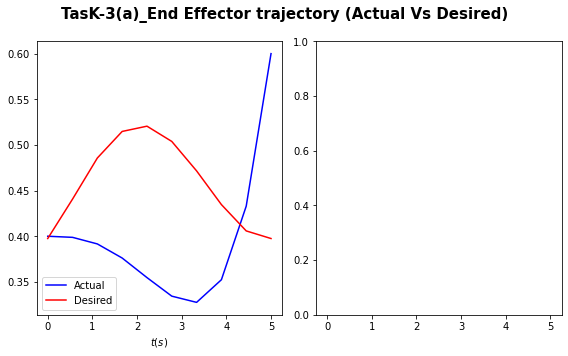

(array([[ 0.4       , -0.9       ,  0.4       ],
       [ 0.44318447, -0.88486511,  0.39878406],
       [ 0.48819794, -0.79855205,  0.3915731 ],
       [ 0.51728395, -0.61728395,  0.37613169],
       [ 0.52305035, -0.35569273,  0.35469525],
       [ 0.50633542, -0.05218717,  0.33437653],
       [ 0.47407407,  0.24567901,  0.32757202],
       [ 0.43716405,  0.49583905,  0.35236837],
       [ 0.40833206,  0.67634507,  0.43294891],
       [ 0.4       ,  0.8       ,  0.6       ]]), array([[0.3975    ],
       [0.44068447],
       [0.48569794],
       [0.51478395],
       [0.52055035],
       [0.50383542],
       [0.47157407],
       [0.43466405],
       [0.40583206],
       [0.3975    ]]))


In [4]:
def pd_controller(qs, qs_, K_P, K_D):                                 #PD control 
    K_P = 3
    K_D = 5
    e = 0.001
    ts = 5
    e_prev = qs_ - np.array(qs)
    e = qs_ - qs
    dedt = (e- e_prev)/5
    u = K_P*e + K_D*dedt
    qs_(u)
    e_prev = e
    print(qs_)
    return qs_ 

def main():   
    qs = tg.generate_joint_poly_trajectory(q_0, q_f, t_f, t_0=t_0, n=n, plot=True)
    robot = Puma()
    print(qs)  
   
if __name__ == '__main__':
    main()

